# Installing packages

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimpg
import zipfile, os
import os
import tensorflow as tf
import split_folders
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from tensorflow.keras.callbacks import Callback

In [ ]:
print(tf.__version__)

2.2.0


# Downloading Data Set

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-07-21 11:59:43--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.44MB/s    in 48s     

2020-07-21 12:00:33 (6.39 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
#ekstraksi berkas .zip
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp/rockpaperscissors')

['rps-cv-images', 'scissors', 'paper', 'rock', 'README_rpc-cv-images.txt']

In [ ]:
#membagi dataset menjadi data latih dan data validasi
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

split_folders.ratio(base_dir, output="/tmp/rockpaperscissors", seed=1337, ratio=(.6, .4))

train_dir = os.path.join("/tmp/rockpaperscissors", 'train')
validation_dir = os.path.join("/tmp/rockpaperscissors", 'val')

Copying files: 2188 files [00:00, 3057.62 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
                      validation_split=0.4,
                      rescale=1./255,
                      rotation_range=20,
                      horizontal_flip=True,
                      shear_range=0.2,
                      fill_mode='nearest')

test_datagen = ImageDataGenerator(
                      validation_split=0.4,
                      rescale=1./255,
                      rotation_range=20,
                      horizontal_flip=True,
                      shear_range=0.2,
                      fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
                          base_dir,
                          target_size=(150, 150),
                          batch_size=32,
                          class_mode='categorical',
                          subset='training',
)
validation_generator = train_datagen.flow_from_directory(
                          base_dir,
                          target_size=(150, 150),
                          batch_size=32,
                          class_mode='categorical',
                          subset='validation',
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}
{'paper': 0, 'rock': 1, 'scissors': 2}


# Modelling

In [ ]:
#Memasukkan callback agar training berhenti setelah mencapai akurasi 99%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy!")
      self.model.stop_training = True

callbacks = myCallback()

#membuat model
model = Sequential([
          Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
          MaxPool2D(2, 2),
          Conv2D(64, (3, 3), activation='relu'),
          MaxPool2D(2, 2),
          Conv2D(128, (3, 3), activation='relu'),
          MaxPool2D(2, 2),
          Conv2D(256, (3, 3), activation='relu'),
          MaxPool2D(2, 2),
          Flatten(),
          Dropout(0.25),
          Dense(512, activation='relu'),
          Dense(3, activation='softmax')])

model.summary()          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Evaluate

In [ ]:
Batch_size = 32
Epoch = 20
history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.n // Batch_size,
          epochs=Epoch,
          validation_data=validation_generator,
          validation_steps=5,
          verbose=2,
          callbacks = [callbacks]
)

Epoch 1/20
41/41 - 59s - loss: 1.0864 - accuracy: 0.3924 - val_loss: 0.8757 - val_accuracy: 0.5875
Epoch 2/20
41/41 - 59s - loss: 0.4821 - accuracy: 0.8159 - val_loss: 0.2930 - val_accuracy: 0.9000
Epoch 3/20
41/41 - 59s - loss: 0.2510 - accuracy: 0.9150 - val_loss: 0.2733 - val_accuracy: 0.8938
Epoch 4/20
41/41 - 59s - loss: 0.2246 - accuracy: 0.9228 - val_loss: 0.3345 - val_accuracy: 0.8875
Epoch 5/20
41/41 - 59s - loss: 0.3133 - accuracy: 0.8892 - val_loss: 0.2856 - val_accuracy: 0.8938
Epoch 6/20
41/41 - 59s - loss: 0.1598 - accuracy: 0.9493 - val_loss: 0.1185 - val_accuracy: 0.9625
Epoch 7/20
41/41 - 62s - loss: 0.1331 - accuracy: 0.9540 - val_loss: 0.0938 - val_accuracy: 0.9812
Epoch 8/20
41/41 - 59s - loss: 0.1767 - accuracy: 0.9384 - val_loss: 0.2342 - val_accuracy: 0.9688
Epoch 9/20
41/41 - 59s - loss: 0.0822 - accuracy: 0.9735 - val_loss: 0.1305 - val_accuracy: 0.9563
Epoch 10/20
41/41 - 59s - loss: 0.0899 - accuracy: 0.9696 - val_loss: 0.1729 - val_accuracy: 0.9375
Epoch 11/

In [ ]:
score = model.evaluate(train_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

42/42 [==============================] - 21s 506ms/step - loss: 0.0316 - accuracy: 0.9901
Loss: 0.0316
Accuracy: 0.9901


In [ ]:
score = model.evaluate(validation_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

28/28 [==============================] - 14s 497ms/step - loss: 0.0646 - accuracy: 0.9805
Loss: 0.0646
Accuracy: 0.9805


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


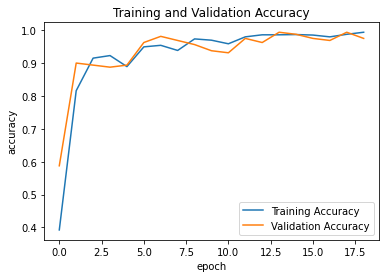

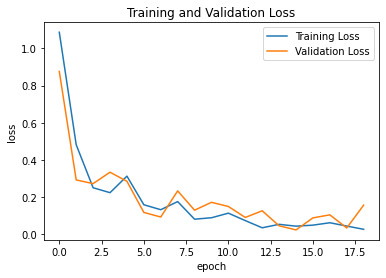

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Result

Saving 0a3UtNzl5Ll3sq8K.png to 0a3UtNzl5Ll3sq8K.png
0a3UtNzl5Ll3sq8K.png
paper


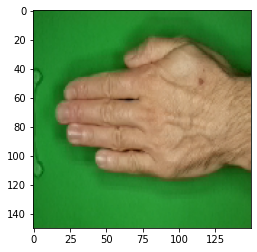

In [ ]:
from google.colab import files
from keras.preprocessing import image
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  
  #prediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print(fn)
  if classes[0,0] == 1.0:
    print('paper')
  elif classes[0,1] == 1.0:
    print('rock')
  elif classes[0,2] == 1.0:
    print('scissors')
